In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from os import path
from PIL import Image, ImageFilter, ImageDraw
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from scipy import interp
from itertools import cycle
import pandas as pd
import seaborn as sn
import shutil
from PIL import ImageEnhance
from sklearn.model_selection import train_test_split

In [9]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ReLU, Dropout, Dense, Flatten
from tensorflow.keras import Model

In [12]:
os.chdir("..")

In [13]:
os.chdir('Images')
path = os.getcwd()
training_classes = [f.name for f in os.scandir(path) if f.is_dir()]
print(training_classes)

['Manhole', 'Pothole']


In [24]:
#counting the number of images in each class
def counters(training_class):
   old_dir=os.getcwd()
   for names in training_class:
    new_path=names
    full_path = os.path.join(path, new_path)
    
     # Change to the new path
    os.chdir(full_path)
    count=0
    for images in os.listdir():
        count+=1
    print(names," : ",count," images")
   os.chdir(old_dir)
    

In [5]:
#counting intially
counters(training_class=training_classes)

Manhole  :  25  images
Pothole  :  300  images


<h3>Data Augmentation</h3>

In [25]:
def rotateImages(folder):
  '''
   Applying Rotation to the images for data augumentation
  '''
  previous_path = os.getcwd()
  os.chdir(folder)
  current_path = os.getcwd()

  for image in os.listdir(current_path):
    # check if the image is already rotated.
    if (image.find("rot") == -1):
      img = Image.open(image)
      # get the image name
      img_name = list(image.split("."))[0]
      rotimg = img.rotate(90)
      # saving the image with its rotation information as well.
      rotimg.save(img_name+"rot"+str(90)+".jpg")
      img.close()
  os.chdir(previous_path)

In [26]:
def addBlur(folder):
  '''
    Adds Blur to the images.
  '''
  previous_path = os.getcwd()
  os.chdir(folder)
  current_path = os.getcwd()
  
  for image in (os.listdir(current_path)):
    if (image.find("rot") == -1):
      img = Image.open(image)
      # adds blur to the image using ImageFilter.Blur
      blured_image = img.filter(ImageFilter.BLUR)
      # get the image name
      img_name = list(image.split("."))[0]
      # saving the image by adding the blur feature.
      blured_image.save(img_name+"blur.jpg")
      
  os.chdir(previous_path)

In [27]:
def Brightness(folder):
  '''
    Adds Blur to the images.
  '''
  previous_path = os.getcwd()
  os.chdir(folder)
  current_path = os.getcwd()
  
  for image in (os.listdir(current_path)):
    if image.find("Brightness") == -1:
        img = Image.open(image)  # Open the image using the image path
        enhancer = ImageEnhance.Brightness(img)  # Pass the image object, not the path

        # Change the brightness (1.0 means original brightness)
        brightness_factor = 1.5  # Increase brightness by 50%
        img_enhanced = enhancer.enhance(brightness_factor)  

         # Increase brightness by 50%
        brightened_image = enhancer.enhance(1.5)
      # get the image name
        img_name = list(image.split("."))[0]
      # saving the image by adding the blur feature.
        brightened_image.save(img_name+"Brightness.jpg")
      
  os.chdir(previous_path)

In [3]:

os.getcwd()
os.chdir("images")

In [28]:
path=os.getcwd()
for names in training_classes:
    new_path=names
    full_path = os.path.join(path, new_path)
    rotateImages(full_path)
    addBlur(full_path)
    Brightness(full_path)


In [29]:
def addHorizontalFlip(folder):
    '''
    Adds horizontal flip to the images in the specified folder.
    Args:
      folder : (str) : Directory containing images.
    '''
    previous_path = os.getcwd()
    os.chdir(folder)
    current_path = os.getcwd()

    for image in os.listdir(current_path):
        # Check if the image has not already been flipped
        if "flip" not in image:
            img_path = os.path.join(current_path, image)  # Full path to the image
            img = cv2.imread(img_path)  # Read the image using OpenCV

            if img is not None:  # Check if the image was loaded successfully
                # Flip the image horizontally
                flipped_image = cv2.flip(img, 1)

                # Get the image name without the extension
                img_name = os.path.splitext(image)[0]

                # Save the flipped image with a new name
                flipped_image_path = os.path.join(current_path, f"{img_name}_flip.jpg")
                cv2.imwrite(flipped_image_path, flipped_image)

    os.chdir(previous_path)

In [30]:
#applying horizontal flip to the Manhole images only to reduce the difference
full_path = os.path.join(path, "Manhole")
addHorizontalFlip(full_path)
counters(training_class=training_classes)

Manhole  :  300  images
Pothole  :  0  images


In [27]:
flip=bright=rotate=blur=nothing=0
for folder in training_classes:
    new_path=os.path.join(path,folder)
    for images in os.listdir(new_path):
        if "flip" in images:
            flip+=1
        if "rot" in images:
            rotate+=1
        if "Brightness" in images:
            bright+=1
        if "blur" in images:
            blur+=1
        if not any(substring in images for substring in ["blur", "flip", "Brightness", "rot"]):
            nothing+=1
print(blur,bright,rotate,flip,nothing)

200 300 200 150 75


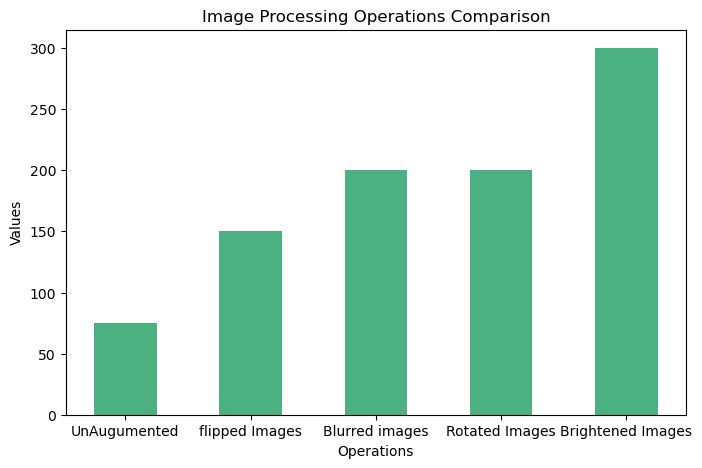

In [37]:
categories = ["UnAugumented","flipped Images","Blurred images","Rotated Images","Brightened Images"]
values = [nothing,flip,blur, rotate, bright ]

# Create the bar graph
plt.figure(figsize=(8, 5))
plt.bar(categories, values, width = 0.5, color='#00904C',alpha=0.7)

# Add titles and labels
plt.title('Image Processing Operations Comparison')
plt.xlabel('Operations')
plt.ylabel('Values')

# Show the bar graph
plt.show()

In [18]:
os.getcwd()


'c:\\Users\\vamsi\\OneDrive\\Desktop\\Documents\\studies\\PROJECTS\\data science\\pothole image detector\\Images'

In [35]:
img_label={}
#Creating Dataset
for folder in training_classes:
    previous_path = os.getcwd()
    os.chdir(folder)
    current_path = os.getcwd()
  # for each image in the current directory
    total_images = 0
    for image in os.listdir(current_path):
        os.rename(image, "c:\\Users\\vamsi\\OneDrive\\Desktop\\Documents\\studies\\PROJECTS\\data science\\pothole image detector\\train\\" + os.path.basename(image))
        if (folder=='Manhole'):
           img_label[image] = np.asarray([1,0], dtype=np.float32)
        else:
           img_label[image] = np.asarray([0,1], dtype=np.float32)

    os.chdir(previous_path)

In [36]:
len(img_label)

600

In [38]:
img_label["1.jpg"]

array([0., 1.], dtype=float32)

In [41]:

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = img / 255.0
    return img

In [43]:
os.chdir("..")

In [45]:
os.getcwd()

'c:\\Users\\vamsi\\OneDrive\\Desktop\\Documents\\studies\\PROJECTS\\data science\\pothole image detector'

In [46]:
os.chdir('train')
image = load_image('1.jpg')
print(f"image has a shape of {image.shape}")

image has a shape of (299, 299, 3)


In [47]:
img_name_train, img_name_val, output_label_train, output_label_val = train_test_split(
                                                                    list(img_label.keys()),
                                                                    list(img_label.values()),
                                                                    test_size=0.1,
                                                                    random_state=0)

print(f'Length of training images = {len(img_name_train)}')
print(f'Length of training labels = {len(output_label_train)}')
print(f"Length of validating images = {len(img_name_val)}")
print(f'Length of validating labels = {len(output_label_val)}')

Length of training images = 540
Length of training labels = 540
Length of validating images = 60
Length of validating labels = 60


In [48]:
os.getcwd()

'c:\\Users\\vamsi\\OneDrive\\Desktop\\Documents\\studies\\PROJECTS\\data science\\pothole image detector\\train'

In [ ]:


channels = 3

train_images = np.ndarray(shape=(len(img_name_train), IMG_SHAPE, IMG_SHAPE, channels), dtype=np.float32)
train_labels = np.ndarray(shape=(len(output_label_train), 3 ), dtype=np.float32)
val_images = np.ndarray(shape=(len(img_name_val), IMG_SHAPE, IMG_SHAPE, channels), dtype=np.float32)
val_labels = np.ndarray(shape=(len(output_label_val), 3 ), dtype=np.float32)

i=0
for image in tqdm(list(img_name_train)):
  x, path = load_image(image)
  train_images[i] = x
  train_labels[i] = np.asarray(output_label_train[i])
  i += 1


i=0
for image in tqdm(list(img_name_val)):
  x, path = load_image(image)
  val_images[i] = x
  val_labels[i] = np.asarray(output_label_val[i])
  i += 1

os.chdir('/content')